In [1]:
# import required libs
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import numpy as np
from copy import copy
from sklearn.metrics import mean_squared_error, ndcg_score, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, kendalltau

In [2]:
hdata_ord = pd.read_pickle('../pickle/hyp_data_ranking.p') # read in the data

gdata_ord = pd.read_pickle('../pickle/graph_data_ranking.p') # read in the data

In [3]:
def xg_hyp(df=hdata_ord,train_size=0.8,learning_rate=0.2,n_estimators=200):
    features = ['degree','centrality1','centrality2','centrality3']
    X = df[features]
    y = df['rank']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    
    model_h = xgb.XGBRanker(  
        tree_method='gpu_hist',
        booster='gbtree',
        objective='rank:pairwise',
        #random_state=42, 
        learning_rate=learning_rate,
        colsample_bytree=0.9, 
        max_depth=15, 
        n_estimators=n_estimators, 
        subsample=0.75 
        )

    model_h.fit(X_train, y_train,group=[int(train_size*497)])

    pred = model_h.predict(df[features])
    hdata_pred = copy(df[['rank']])
    hdata_pred['pred'] = pred
    hdata_pred = hdata_pred.sort_values('pred', ascending=False)
    hdata_pred['pred_rank'] = range(497,0,-1)
    hdata_pred = hdata_pred.sort_values('rank')
    return hdata_pred

In [4]:
def xg_pair(df=gdata_ord,train_size=0.8,learning_rate=0.2,n_estimators=200):
    gfeatures = ['degree','centrality']
    X = df[gfeatures]
    y = df['rank']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    
    model_g = xgb.XGBRanker(  
        tree_method='gpu_hist',
        booster='gbtree', 
        objective='rank:pairwise',
        #random_state=42, 
        learning_rate=learning_rate,
        colsample_bytree=0.9, 
        max_depth=15, 
        n_estimators=n_estimators, 
        subsample=0.75 
        )

    model_g.fit(X_train, y_train,group=[int(train_size*497)])
    
    gpred = model_g.predict(df[gfeatures])
    gdata_pred = copy(df[['rank']])
    gdata_pred['pred'] = gpred
    gdata_pred = gdata_pred.sort_values('pred',ascending=False)
    gdata_pred['pred_rank'] = range(497,0,-1)
    gdata_pred = gdata_pred.sort_values('rank')
    return gdata_pred

In [5]:
def corr(df) -> dict:

    rank = df['rank']

    pred_rank = df['pred_rank']

    correlations = {}

    correlations['mse'] = mean_squared_error([rank],[pred_rank])

    correlations['ndcg'] = ndcg_score([rank],[pred_rank])

    correlations['ktau'] = kendalltau(pred_rank,list(range(1,498)))[0]

    correlations['pval-ktau'] = kendalltau(pred_rank,list(range(1,498)))[1]

    correlations['pearsonr'] = pearsonr(rank,pred_rank)[0]

    correlations['pval-pearsonr'] = pearsonr(rank,pred_rank)[1]
    
    correlations['r2'] = r2_score(rank, pred_rank)

    return correlations

In [6]:
def pretty_corr(c): # pretty print output from corr()
    print(f"""
    Mean squared error (RMS): \t{c['mse']:.0f} ({c['mse']**.5:.5})
    Normalised discounted
      cumulative gain: \t\t{c['ndcg']:.5}
    Kendall Tau: \t\t{c['ktau']:.5}
    \tKtau p-value: \t\t{c['pval-ktau']:.5}
    Pearson's r: \t\t{c['pearsonr']:.5}
    \tPearson's r p-value: \t{c['pval-pearsonr']:.5}
    Coef. of determination \t{c['r2']:.5}
    """)

In [7]:
def met_avgs(met_list) -> dict: # given a list of dictionaries of metrics, return a dict of their averages
    keys = met_list[0].keys()
    list_len = len(met_list)
    ret_dict = {}
    for k in keys:
        ret_dict[k] = 0
    for d in met_list:
        for m in d:
            ret_dict[m] += d[m]
    for m in ret_dict:
        ret_dict[m]/=list_len
    
    return ret_dict

# Training and Plots

In [8]:
ts = 0.8 # training size
lr = 0.2 # learning rate
n_t = 150 # n_estimators (number of trees)

In [9]:
h_pred = xg_hyp(df=hdata_ord,train_size=ts,learning_rate=lr,n_estimators=n_t)
g_pred = xg_pair(df=gdata_ord,train_size=ts,learning_rate=lr,n_estimators=n_t)
    
h_corr = corr(h_pred)
g_corr = corr(g_pred)

In [10]:
# Pretty print the correlations
print("-----------------------------------------")
print("Hypergraph ranking correlations:")
pretty_corr(h_corr)
print("-----------------------------------------")
print("Pair graph ranking correlations:")
pretty_corr(g_corr)

-----------------------------------------
Hypergraph ranking correlations:

    Mean squared error (RMS): 	6372 (79.824)
    Normalised discounted
      cumulative gain: 		0.98184
    Kendall Tau: 		0.70111
    	Ktau p-value: 		1.0167e-120
    Pearson's r: 		0.84522
    	Pearson's r p-value: 	8.452e-137
    Coef. of determination 	0.69044
    
-----------------------------------------
Pair graph ranking correlations:

    Mean squared error (RMS): 	16059 (126.72)
    Normalised discounted
      cumulative gain: 		0.96266
    Kendall Tau: 		0.43719
    	Ktau p-value: 		4.4653e-48
    Pearson's r: 		0.60991
    	Pearson's r p-value: 	5.7994e-52
    Coef. of determination 	0.21983
    


In [11]:
#get coefficients for line of best fit
hm, hb = np.polyfit(h_pred['rank'],h_pred['pred_rank'],1)
gm, gb = np.polyfit(g_pred['rank'],g_pred['pred_rank'],1)

[Text(0.5, 0, 'Empirical Rank'), Text(0.5, 1.0, 'Pairwise Graph'), None]

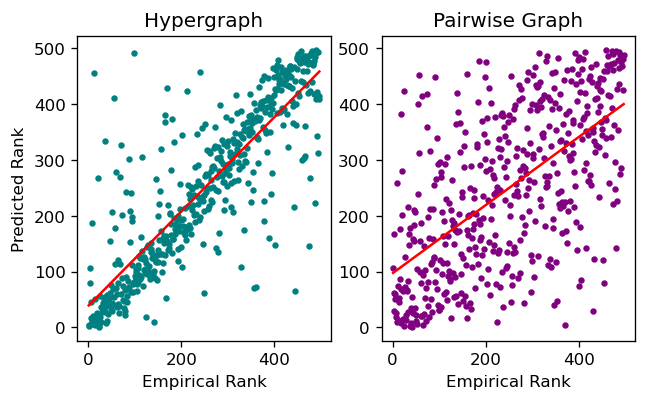

In [12]:
_, (ax1, ax2) = plt.subplots(1, 2, dpi=120)

ax1.scatter(h_pred['rank'],h_pred['pred_rank'], c='teal', s=8)
ax1.plot(h_pred['rank'],hm*h_pred['rank']+hb,c='red') # line of best fit 
ax1.set(xlabel='Empirical Rank',ylabel='Predicted Rank',title='Hypergraph',aspect=1.2)

ax2.scatter(g_pred['rank'],g_pred['pred_rank'], c='purple', s=8)
ax2.plot(g_pred['rank'],gm*g_pred['rank']+gb,c='red') # line of best fit 
ax2.set(xlabel='Empirical Rank',title='Pairwise Graph',aspect=1.2)